# Analyse BlueSeis BSPF Event Analysis - Coherence

In [22]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

In [23]:
from functions.compute_backazimuth import __compute_backazimuth

In [24]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [25]:
def __rolling_average(arr, win_size=5):
    
    from numpy import ones, array
    from scipy.signal import convolve, hanning
    
    data = array(arr)
    window = ones(win_size)/float(win_size)
    window = hanning(win_size)/float(win_size)
    rolling_average = convolve(data, window, mode='valid')

    return rolling_average

## Configurations

In [26]:
config = {}

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## 
config['path_to_mseed'] = data_path+"BSPF/data/waveforms/"

## event selction
config['path_to_data'] = data_path+"BSPF/data/"

## output path for figures
config['output_figs'] = data_path+"BSPF/figures/velocity/"


## Load Data

In [27]:
# !ls /home/andbro/kilauea-data/BSPF/data/catalogs/

### load event and trigger data

In [28]:
events = obs.read_events(config['path_to_data']+"catalogs/BSPF_catalog_20221001_20230615_all.xml")

triggered = pd.read_pickle(config['path_to_data']+"catalogs/BSPF_catalog_20221001_20230615_triggered.pkl")

event_times = pd.read_pickle(config['path_to_data']+"event_selection_good.pkl")

### select event

In [29]:
num = 1

event_time = event_times.origin_time.loc[num]

event = events.filter(f"time >= {event_time}",f"time <= {event_time}")

trig = triggered[triggered.origin == event_time]

## prepare string
event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")

### load stream

In [30]:
st = obs.read(config['path_to_mseed']+f"*{event_time_str}*")

st.detrend("simple")


# config['fmin'], config['fmax'] = 5.0, 50.0
# st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

# st.plot(equal_scale=False);

# cut_offs = [
#     (65,80), (65,80), (60,100), (60,100), (60,70),
#     (60,90), (60,90), (60,90), (62,105), (65,90),
#     (62,110), (65,85), (60,105),
# ]

# st.trim(st[0].stats.starttime+cut_offs[num][0], st[0].stats.endtime-cut_offs[num][1]);

12 Trace(s) in Stream:
II.PFO.10.BHE  | 2022-10-07T22:44:05.469539Z - 2022-10-07T22:47:05.469539Z | 40.0 Hz, 7201 samples
II.PFO.10.BHN  | 2022-10-07T22:44:05.469539Z - 2022-10-07T22:47:05.469539Z | 40.0 Hz, 7201 samples
II.PFO.10.BHZ  | 2022-10-07T22:44:05.469539Z - 2022-10-07T22:47:05.469539Z | 40.0 Hz, 7201 samples
II.RPFO.al.BJE | 2022-10-07T22:44:05.469539Z - 2022-10-07T22:47:05.469539Z | 40.0 Hz, 7201 samples
II.RPFO.al.BJN | 2022-10-07T22:44:05.469539Z - 2022-10-07T22:47:05.469539Z | 40.0 Hz, 7201 samples
II.RPFO.al.BJZ | 2022-10-07T22:44:05.469539Z - 2022-10-07T22:47:05.469539Z | 40.0 Hz, 7201 samples
II.RPFO.in.BJE | 2022-10-07T22:44:05.469539Z - 2022-10-07T22:47:05.469539Z | 40.0 Hz, 7201 samples
II.RPFO.in.BJN | 2022-10-07T22:44:05.469539Z - 2022-10-07T22:47:05.469539Z | 40.0 Hz, 7201 samples
II.RPFO.in.BJZ | 2022-10-07T22:44:05.469539Z - 2022-10-07T22:47:05.469539Z | 40.0 Hz, 7201 samples
PY.BSPF..HJE   | 2022-10-07T22:44:05.472300Z - 2022-10-07T22:47:05.472300Z | 40.0 Hz, 

## Coherence


In [31]:
def __coherence_in_octaves(st_in, fmin, fmax):

    from numpy import arange, mean
    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from scipy.signal import coherence
    
    flower, fupper, fcenter = __get_octave_bands(fmin, fmax, fband_type="octave")
    fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

    ## _____________________

#     ddf = 3
#     fcenter = arange(fmin+ddf, fmax-ddf, 1)
#     fbands = [(fc - ddf, fc + ddf) for fc in fcenter] 
    
    df_out = DataFrame()
    
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    
    for ii, comp in enumerate(["Z","N","E"]):

        tr1 = st_in.select(station="BSPF", channel=f'*{comp}')[0]
        tr2 = st_in.select(station="RPFO", location="in", channel=f'*{comp}')[0]
        tr3 = st_in.select(station="RPFO", location="al", channel=f'*{comp}')[0]
        
        co2, co3 = [],[]
        for (fl, fu) in fbands:
            s1, s2, s3 = tr1.copy(), tr2.copy(), tr3.copy()
            
            s1 = s1.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            s2 = s2.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            s3 = s3.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            
            s1 = s1.normalize()
            s2 = s2.normalize()
            s3 = s3.normalize()

            s1 = s1.taper(0.1)
            s2 = s2.taper(0.1)
            s3 = s3.taper(0.1)
            
            df = s1.stats.sampling_rate
            tseg = 1/fl*20
            nseg = int(df*tseg)
            
#             ff2, coh2 = coherence(s1.data, s2.data, fs=df, window='hann',nperseg=nseg, noverlap=int(0.5*nseg))
#             ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann',nperseg=nseg, noverlap=int(0.5*nseg))
            ff2, coh2 = coherence(s1.data, s2.data, fs=df, window='hann')
            ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann')
        
            for i in range(len(ff2)):
                if ff2[i] < fl or ff2[i] > fu:
                    coh2[i], coh3[i] = 0, 0
        
#             plt.figure()
#             plt.plot(ff2, coh2)
#             plt.show()
            
            co2.append(max(coh2))
            co3.append(max(coh3))
            
        df_out[f'{comp}_in_fc'] = fcenter
        df_out[f'{comp}_in_co']  = co2
        df_out[f'{comp}_al_fc'] = fcenter
        df_out[f'{comp}_al_co']  = co3
                 
        ax[ii].scatter(fcenter, co2, s=50, label="BSPF-RPFO_inner")
        ax[ii].plot(fcenter, co2, ls="-")

        ax[ii].scatter(fcenter, co3, s=50, label="BSPF-PRFO_all")
        ax[ii].plot(fcenter, co3, ls="-")

        ax[ii].set_title(f"max. coherence {comp}")
        ax[ii].legend()
        ax[ii].set_xscale("log")
        ax[ii].grid(ls="--",zorder=0,alpha=.5, which="both")
    plt.show();
        
    return df_out

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (22.627416997969522) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


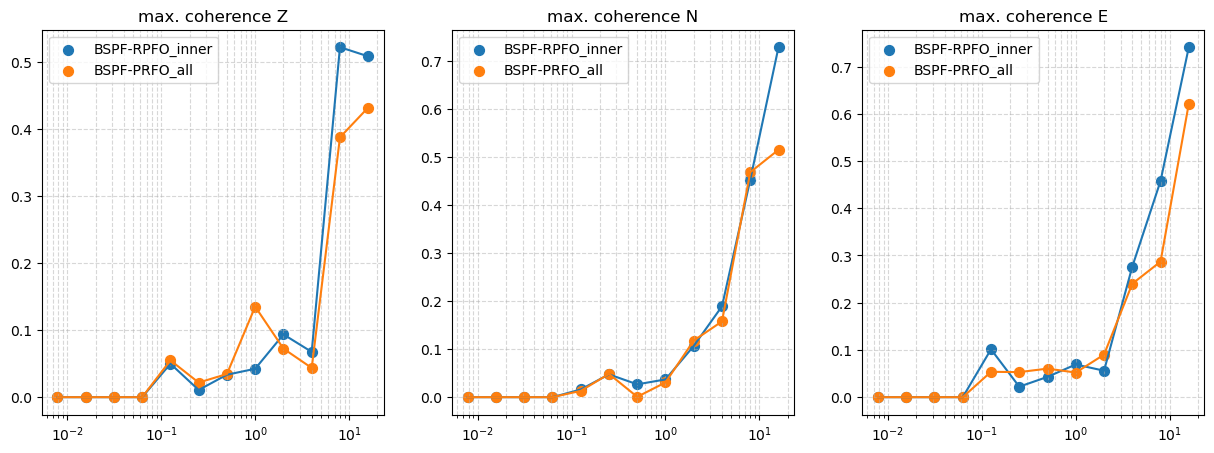

In [32]:
fmin, fmax = 0.01, 18

df_coh = __coherence_in_octaves(st, fmin, fmax)

## Cross Correlation

In [33]:
def __cc_in_octaves(st_in, fmin, fmax):

    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from functions.compute_cc_for_fbands import __compute_cc_for_fbands
    
    flower, fupper, fcenter = __get_octave_bands(fmin, fmax, fband_type="one-third-octave")

    fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

    ## _____________________

#     fbands = [(1,5),(2,6),(3,7),(4,8),(5,9),(6,10),(7,11),(8,12),(9,13),(10,14),(11,15),(12,16),(13,17),(14,18)]
#     fbands = [(1,2),(2,4),(3,6),(4,8),(5,10),(6,12),(7,14),(8,16), (9,18), (10,20)]

    df_out = DataFrame()
    
    for comp in ["Z","N","E"]:

        print(comp)

        plt.figure(figsize=(15,5))

        tr1 = st_in.select(station="BSPF", channel=f'*{comp}')[0]
        tr2 = st_in.select(station="RPFO", location="in", channel=f'*{comp}')[0]
        tr3 = st_in.select(station="RPFO", location="al", channel=f'*{comp}')[0]
        
        
        ff, cc_t_max, cc_f_max = __compute_cc_for_fbands(tr1, tr2, fbands=fbands, plot=False)
        
        df_out[f'{comp}_in_fband'] = ff
        df_out[f'{comp}_in_cc_t'] = cc_t_max
        df_out[f'{comp}_in_cc_f'] = cc_f_max
        
        plt.scatter(ff, cc_t_max, color="r")
        plt.scatter(ff, cc_f_max, color="r")

        ff, cc_t_max, cc_f_max = __compute_cc_for_fbands(tr1, tr3, fbands=fbands, plot=False)

        df_out[f'{comp}_al_fband'] = ff
        df_out[f'{comp}_al_cc_t'] = cc_t_max
        df_out[f'{comp}_al_cc_f'] = cc_f_max
        
        plt.scatter(ff, cc_t_max)
        plt.scatter(ff, cc_f_max) 

    #     plt.xscale("log")
        plt.show()
        
    return df_out

In [ ]:
df_cc = __cc_in_octaves(st, fmin, fmax)
df_cc

In [ ]:
import seaborn as sns

dff = __stream_to_dataframe(st)

matrix = dff.corr().round(2)

sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')

In [ ]:
s1, s2, s3 = tr1.copy(), tr2.copy(), tr3.copy()

fl=8
fu=10


s1 = s1.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
s2 = s2.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
s3 = s3.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)

s1 = s1.normalize()
s2 = s2.normalize()
s3 = s3.normalize()

ff, co = coherence(    
                    s1,
                    s2,
                    fs=40.0,
                    window='hann',
                    nperseg=None,
                    noverlap=None,
                    nfft=None,
                    detrend='constant',
                    axis=-1,
)

plt.semilogx(ff,co)

## AS LOOP

In [ ]:
# for i in range(0,17):
    
#     event_time = event_times.origin_time.loc[i]
    
#     try:
#         event = events.filter(f"time >= {event_time}",f"time <= {event_time}")
        
#         event_time = event_times.origin_time.loc[i]

#         trig = triggered[triggered.origin == event_time]

#     except:
#         print(f" -> {i} no event")
        
#     ## prepare string
#     event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")
     
#     ## load data
#     st = obs.read(config['path_to_mseed']+f"*{event_time_str}*")

#     st.detrend("simple")

#     st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

    
#     out['fig'].savefig(config['output_figs']+f"{event_time_str}_rayleigh_velocity.png", dpi=200, bbox_inches='tight', pad_inches=0.05)